In [2]:
from tensorflow.keras.models import load_model

# 모델 로드
model = load_model('..best_cnn_lstm_model.keras')
print("Model loaded successfully.")

Model loaded successfully.


/opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [31]:
from tensorflow.keras.models import load_model
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import ta


# NVDA 데이터 다운로드 (2024-08-01부터 2024-09-02까지)
data = yf.download("NVDA", start="2024-01-01", end="2024-08-30")

# 데이터 확인
print(data.head(5))


[*********************100%***********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2024-01-02  49.243999  49.294998  47.595001  48.167999  48.161785  411254000
2024-01-03  47.485001  48.183998  47.320000  47.569000  47.562862  320896000
2024-01-04  47.766998  48.500000  47.507999  47.998001  47.991810  306535000
2024-01-05  48.462002  49.547001  48.306000  49.097000  49.090664  415039000
2024-01-08  49.512001  52.275002  49.479000  52.252998  52.246254  642510000


In [32]:
# 기술 지표 계산
data['EMA_14'] = ta.trend.ema_indicator(close=data['Close'], window=14)
data['RSI_14'] = ta.momentum.rsi(close=data['Close'], window=14)
data['MACD'] = ta.trend.macd(data['Close'])
data['MACD_signal'] = ta.trend.macd_signal(data['Close'])
data['MACD_diff'] = ta.trend.macd_diff(data['Close'])
bollinger = ta.volatility.BollingerBands(close=data['Close'], window=20, window_dev=2)
data['BB_High'] = bollinger.bollinger_hband()
data['BB_Low'] = bollinger.bollinger_lband()
data['BB_Mid'] = bollinger.bollinger_mavg()
data['SMA_30'] = ta.trend.sma_indicator(close=data['Close'], window=30)
data['MAD_30'] = data['Close'].rolling(window=30).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=True)

# 결측치 처리
data = data.dropna()


In [33]:
# 피처 선택 및 정규화
features = data[['EMA_14', 'RSI_14', 'MACD', 'MACD_signal', 'MACD_diff', 'BB_High', 'BB_Low', 'BB_Mid', 'SMA_30', 'MAD_30']]
feature_scaler = MinMaxScaler()
scaled_features = feature_scaler.fit_transform(features)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Predicted price for 2024-08-30: 125.02263641357422


[*********************100%***********************]  1 of 1 completed

Actual price on 2024-08-30: 119.37000274658203
Difference between actual and predicted price: -5.6526336669921875


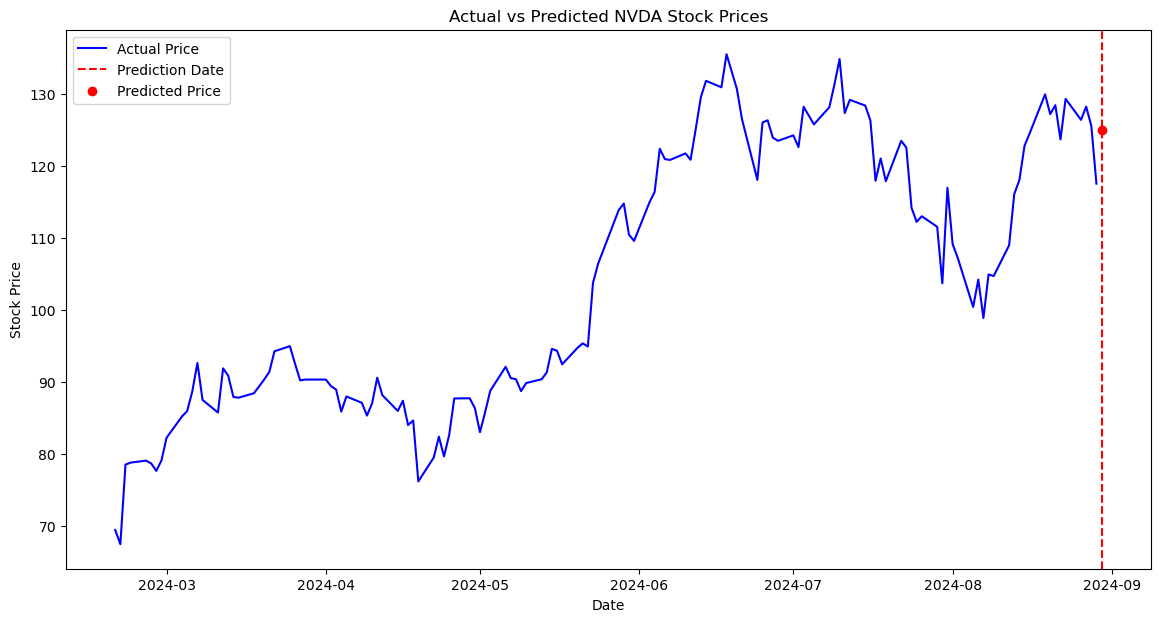

In [35]:
# 시퀀스 생성 함수
def create_sequences(X, time_steps=60):
    Xs = []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
    return np.array(Xs)
# 시퀀스 생성
X_last = create_sequences(scaled_features, time_steps=60)

# 예측 수행
predicted_scaled = model.predict(X_last)

# 예측 결과를 원래 스케일로 되돌림
# `target`에 대해 학습된 스케일러 사용
target_scaler = MinMaxScaler()
target_scaler.fit(data['Close'].values.reshape(-1, 1))  # 기존 데이터로 scaler를 fit
predicted_price = target_scaler.inverse_transform(predicted_scaled)

# 마지막 예측값
predicted_price_for_date = predicted_price[-1, 0]
print(f"Predicted price for 2024-08-30: {predicted_price_for_date}")

# 실제 데이터 다운로드 (2024-08-30)
actual_data = yf.download("NVDA", start="2024-08-30", end="2024-08-31")
actual_price_for_date = actual_data['Close'].values[0]

# 차이 계산
price_difference = actual_price_for_date - predicted_price_for_date
print(f"Actual price on 2024-08-30: {actual_price_for_date}")
print(f"Difference between actual and predicted price: {price_difference}")

# 시계열 데이터 추출
actual_dates = data.index
actual_prices = data['Close']

# 시각화
plt.figure(figsize=(14, 7))
plt.plot(actual_dates, actual_prices, label='Actual Price', color='blue')
plt.axvline(x=pd.to_datetime("2024-08-30"), color='r', linestyle='--', label='Prediction Date')

# 실제와 예측값 표시
plt.scatter(pd.to_datetime("2024-08-30"), predicted_price_for_date, color='red', marker='o', label='Predicted Price')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted NVDA Stock Prices')
plt.legend()
plt.show()